In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import json
import os
import yaml
from dask.distributed import Client

In [4]:
with open('/g/g92/haridev/.dlio_profiler/configuration.yaml', 'r') as file:
    dlp_yaml = yaml.safe_load(file)

In [5]:
# to make this notebook in dev mode.
import sys
sys.path.insert(0,dlp_yaml["APP"])
sys.path

['/usr/WS2/haridev/dlio-profiler',
 '/usr/WS2/haridev/dlio-profiler/examples/dlp_analyzer',
 '/usr/WS2/haridev/dlio-profiler/examples/dlp_analyzer',
 '/usr/workspace/iopp/projects/digio',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python39.zip',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9/lib-dynload',
 '',
 '/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages']

In [6]:
import dlp_analyzer
print(dlp_analyzer.__file__)
from dlp_analyzer.main import DLPAnalyzer,get_dlp_configuration,update_dlp_configuration,setup_logging,setup_dask_cluster, reset_dask_cluster, get_dlp_configuration

/usr/WS2/haridev/dlio-profiler/dlp_analyzer/__init__.py


In [7]:
dask_run_dir = os.path.join(dlp_yaml["APP"], "dlp_analyzer", "dask", "run_dir")
dask_run_dir

'/usr/WS2/haridev/dlio-profiler/dlp_analyzer/dask/run_dir'

In [8]:
with open (os.path.join(dask_run_dir, "scheduler.json"), "r") as f:
    dask_scheduler = json.load(f)
dask_scheduler

{'type': 'Scheduler',
 'id': 'Scheduler-89209c3b-66f7-4b23-9420-c0d0848be547',
 'address': 'tcp://134.9.71.27:10001',
 'services': {'dashboard': 8787},
 'started': 1698518019.2896266,
 'workers': {}}

In [9]:
conf = update_dlp_configuration(dask_scheduler=dask_scheduler["address"], verbose=True, log_file="./dlp.log", rebuild_index=False, time_approximate=True, host_pattern=r'ruby(\d+)', time_granularity=40e6)


In [10]:
conf = get_dlp_configuration()
conf.time_approximate

True

In [11]:
setup_logging()

In [12]:
setup_dask_cluster()

[INFO] [13:41:50] Initialized Client with 48 workers and link http://134.9.71.27:8787/status [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:593]


In [13]:
reset_dask_cluster()

[INFO] [13:41:55] Restarting all workers [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:585]


In [14]:
filename = "/p/lustre1/iopp/dlp/cosmoflow-profile-compress-meta-scale-all-512/.trace*.pfw.gz"
#filename = "/p/lustre1/iopp/dlp/cosmoflow-profile-compress-meta-scale-all-512/.trace-3*-of-512.pfw.gz"
filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark_logs/unet3d/node_32_ppn_4/.trace*.pfw.gz"

In [15]:
analyzer = DLPAnalyzer(filename)

[INFO] [13:41:56] Created index for 128 files [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:318]
[INFO] [13:41:56] Total size of all files are <dask.bag.core.Item object at 0x1554a7cf2f10> bytes [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:320]
[INFO] [13:41:56] Loading 768 batches out of 128 files and has 11996460 lines overall [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:333]
[INFO] [13:42:08] Loaded events [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:364]
[INFO] [13:42:08] Loaded plots with slope threshold: 45 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:366]


In [16]:
val = analyzer.events.groupby(["trange"]).agg({"io_time":[min,max],"compute_time":[min,max],"app_io_time":[min,max]}).sum().compute()
val

io_time       min           0
              max     1620179
compute_time  min     2721618
              max     2743263
app_io_time   min      239438
              max    27155079
dtype: uint64[pyarrow]

In [17]:
val = analyzer.events["app_io_time"].max().compute()
val

21788614

In [18]:
import dask
val1, val2 = dask.compute(analyzer.events["ts"].min() /1e6 , analyzer.events["ts"].max()/1e6)
val2 - val1

105.51145505905151

In [19]:
analyzer.events["hostname"].unique().compute()[:2]

0    ruby165
1    ruby926
Name: hostname, dtype: string

In [20]:
items = analyzer.summary()
items

[INFO] [13:42:09] Total number of events in the workload are 11996204 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:456]
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please pr

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  Allocation    Scheduler Allocation Details                                                                     │
│                ├── Nodes: 32 ruby[165,1253]                                                                     │
│                ├── Processes: 128 [0,127]                                                                       │
│                ├── Thread allocations across nodes (includes dynamically created threads)                       │
│                │   ├── Compute: 128                                                                             │
│                │   └── I/O: 2304                                                                                │
│                └── Events Recorded: 11996204                                                                    │
│  Dataset       Description of Dataset Used                                                                      │
│                └── Files: 171 ['<NA>',                                                                          │
│                    '/p/lustreX/kogiouX/dlio_benchmark_results/unetXd/train/img_XXX_of_XXX.npz',                 │
│                    '/p/lustreX/kogiouX/dlio_benchmark_results/unetXd/train',                                    │
│                    '/p/lustreX/kogiouX/dlio_benchmark_results/unetXd/valid']                                    │
│  I/O Behavior  Behavior of Application                                                                          │
│                ├── Split of Time in application                                                                 │
│                │   ├── Total Time: 27.155 sec                                                                   │
│                │   ├── Overall App Level sI/O: 27.155 sec                                                       │
│                │   ├── Unoverlapped App I/O: 24.412 sec                                                         │
│                │   ├── Unoverlapped App Compute: 0.000 sec                                                      │
│                │   ├── Compute: 2.743 sec                                                                       │
│                │   ├── Overall I/O: 1.620 sec                                                                   │
│                │   ├── Unoverlapped I/O: 0.000 sec                                                              │
│                │   └── Unoverlapped Compute: 1.123 sec                                                          │
│                ├── Transfer size distribution by function                                                       │
│                │   ├── Function       |min   |25    |mean  |median|75    |max   |                               │
│                │   ├── opendir        |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── __xstat64      |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── open64         |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── __fxstat64     |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── lseek64        |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── read           |NA    |4MB   |4MB   |4MB   |4MB   |4MB   |                               │
│                │   └── close          |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                └── Event count by function                                                                      │
│                    ├── opendir : 5372                                                                           │
│                    ├── __xstat64 : 5372               

In [21]:
analyzer.events.query("name == 'lseek64'").groupby("trange")["dur"].max().sum().compute() / 10e6

0.0094262

In [22]:
analyzer.events.groupby(["cat","name"])["dur"].sum().compute()

cat             name                                 
POSIX           __fxstat64                                  222217739
                __xstat64                                   237376060
                close                                       307155133
                lseek64                                      44250088
                open64                                      358131782
                opendir                                     265005180
                read                                      14882912576
ai_framework    TorchFramework.__init__                         22475
                TorchFramework.checkpoint                     6178527
                TorchFramework.compute                     7840522796
                TorchFramework.get_loader                       46132
                TorchFramework.init_loader                 4444766486
                TorchFramework.is_nativeio_available            24139
                TorchFramework.trace

In [23]:
3766287/3.8/1e6, 1022647/3.8/1e6, 1080267/3.8/1e6, 178451/3.8/1e6, (1259124+153089)/3.8/1e6

(0.9911281578947368,
 0.26911763157894736,
 0.28428078947368424,
 0.04696078947368421,
 0.371635)

[INFO] [13:53:37]             index           size  total_time  io_time  app_io_time
trange                                                            
21229401  6398146  6057549130908    21788614  1320738     21788614
21229402  5598058  6039041094497     5366465   299441      5366465 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/plots.py:224]
[INFO] [13:53:38]             index           size  total_time  io_time  app_io_time
trange                                                            
21229401  6398146  6057549130908    21788614  1320738     21788614
21229402  5598058  6039041094497     5366465   299441      5366465 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/plots.py:94]
[INFO] [13:53:38]         index  size  total_time  io_time  app_io_time
trange                                               
1           1     1           1        1            1
2           1     2           2        2            2 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/plots.py:69]


ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

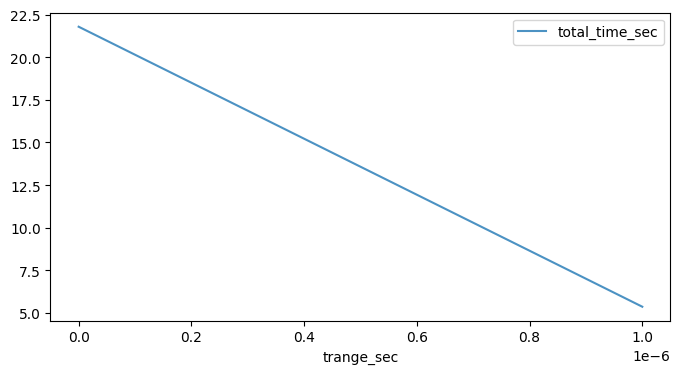

In [37]:
analyzer.plots.bottleneck_timeline(figsize=(8, 4))

In [ ]:
analyzer.plots.bw_timeline(figsize=(4, 4), unit='KB')

[INFO] [13:52:38]             index           size  total_time  io_time  app_io_time
trange                                                            
21229401  6398146  6057549130908    21788614  1320738     21788614
21229402  5598058  6039041094497     5366465   299441      5366465 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/plots.py:224]


<Axes: xlabel='Transfer Sizes', ylabel='Frequency'>

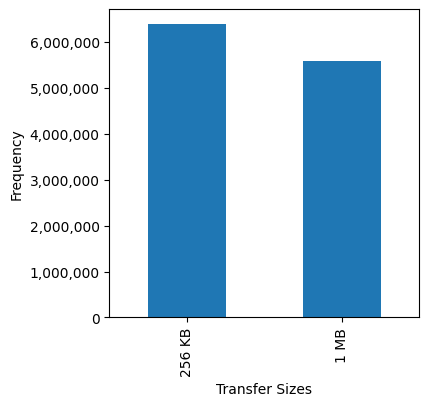

In [35]:
analyzer.plots.xfer_size_distribution(figsize=(4, 4))